# Plot hypsometry and SNOTEL site elevations for a given basin
---  
*J. Michelle Hu  
University of Utah  
Nov 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
import seaborn as sns

from pathlib import PurePath
from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

# Set seaborn palette
sns.set_palette('icefire')

In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


In [4]:
# pd.options.plotting.backend = 'matplotlib'

## Read in hypsometry of basins

In [16]:
# Read in hypsometry of basin (produced in spatial_basin.ipynb)
import seaborn as sns
sns.set_palette('icefire')

# Hypsometry plots
# Load up hypsometry.csv files
# csv_fns = h.fn_list('./', '*hypsometry.csv')
# basin_names = [PurePath(csv_fn).name.split('_hypsometry')[0] for csv_fn in csv_fns]
# rearrange for plotting?
basin_names = ['yampa', 'blue', 'animas']
csv_fns = [h.fn_list('./', f'{basin}*hypsometry*bins.csv')[0] for basin in basin_names]


df_list = [pd.read_csv(csv_fn) for csv_fn in csv_fns]
colors = ['teal', 'mediumaquamarine', 'mediumslateblue']
print(csv_fns)

['./yampa_hypsometry_20bins.csv', './blue_hypsometry_20bins.csv', './animas_hypsometry_20bins.csv']


### Directories and global variables

In [17]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/polys'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'

In [18]:
buffer = 0

In [19]:
# Basin-specific variables
basin_elevs = dict()
for basin in basin_names:
    # Select just for all variable output of time decay
    basindirs = h.fn_list(workdir, f'{basin}*/wy*/{basin}*/')

    # Get the WY from the directory name - assumes there is only one WY per basin right now
    WYs = [int(basindir.split('wy')[1][:4]) for basindir in basindirs]
    WYs = np.unique(WYs)
    if len(WYs) == 1:
        pass
    else:
        print(f'Multiple water years in {basin} basin: {WYs}')
    WY = WYs[0]
    print(f'WY: {WY}')

    # Figure out filenames
    poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
    print(poly_fn)
    
    # SNOTEL extraction and point specification
    # identify SNOTEL sites within the specified basin
    # extract site metadata (site name, site number, and coordinates)
    # Locate SNOTEL sites within basin
    found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn, buffer=buffer)

    # Get site names and site numbers
    sitenames = found_sites['site_name']
    sitenums = found_sites['site_num']
    print(sitenames)

    ST_arr = ['CO'] * len(sitenums)
    _, _, snotel_metadf = proc.get_snotel(sitenums, sitenames, ST_arr, WY=WY, return_meta=True) 
    
    # Convert elevation of snotel points to meters
    elev_m_list = [site.z * 12 * 2.54 / 100 for site in snotel_metadf]
    # print(f'Elevation: {site.z:.0f} ft, {elev_m:.0f} m')
    basin_elevs[basin] = elev_m_list
    print('\n')

Multiple water years in yampa basin: [2020 2024]
WY: 2020
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/yampa_setup/polys/upper_yampa_basin_outline_32613.shp
136     Bear River (1061)
145    Buffalo Park (913)
156          Crosho (426)
160        Dry Lake (457)
163       Elk River (467)
188        Lost Dog (940)
211     Rabbit Ears (709)
214    Ripple Creek (717)
229           Tower (825)
Name: site_name, dtype: object


WY: 2019
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/polys/blue_river_basin_outline_HUC10dissolved_32613.shp
155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
Name: site_name, dtype: object


WY: 2021
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/animas_setup/polys/animas_basin_outline_HUC10_32613.shp
148           Cascade #2 (387)
199        Mineral Creek (629)
200           Molas Lake (632)
213    Red Mountain Pass (713)
225        Spud Mountain (780

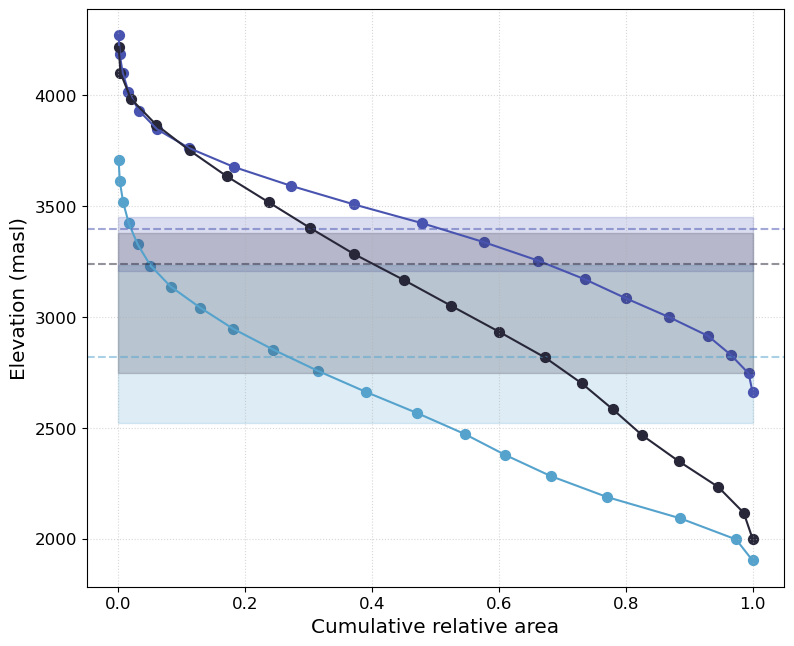

In [24]:
savefig = False
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Plot hypsometry and snotel points on the same plot
if savefig:
    fig, ax = plt.subplots(1, figsize=(9, 5))
else:
    fig, ax = plt.subplots(1, figsize=(9, 7.5))
for jdx, (df, basin) in enumerate(zip(df_list, basin_names)):
    # Plot hypsometry area vs elevation for each basin
    ax.scatter(df['cumulative_rel_area'], df['mean_elevation_m'], label=basin, s=50)
    ax.plot(df['cumulative_rel_area'], df['mean_elevation_m'])
    
    # Pull snotel elevations for the basin
    elev_df = pd.Series(basin_elevs[basin])
    
    # Extract SNOTEL stats
    # Plot as shaded areas or dotted horizontal lines at the elevation levels
    _, _, _, snotelmin, low_quart, med, high_quart, snotelmax = elev_df.describe()
    p = 25
    plow = np.nanpercentile(elev_df, p)
    phigh = np.nanpercentile(elev_df, 100-p)
    
    xmin, xmax = -0.05, 1.05
    
    # Median line
    ax.axhline(y=med, xmin=0, xmax=xmax, color=sns.color_palette()[jdx], linestyle='--', alpha=0.5)
    
    # Filled areas
    # ax.fill_between(y1=low_quart, y2=high_quart, x=np.arange(0, 1.1), color=sns.color_palette()[jdx], alpha=0.2, label=f'{basin} SNOTEL IQR')
    # ax.fill_between(y1=plow, y2=phigh, x=(xmin, xmax), color=sns.color_palette()[jdx], alpha=0.2, label=f'{basin} SNOTEL {p}-{100-p}%')
    ax.fill_between(y1=snotelmin, y2=snotelmax, x=np.arange(0, 1.1), color=sns.color_palette()[jdx], alpha=0.2, label=f'{basin} SNOTEL range')
    
    # # Annotate with elevation text here
    # ax.annotate(text=f'{df["mean_elevation_m"][1]:.0f} m', xy=(0.51, df['mean_elevation_m'][1]+25), color=sns.color_palette()[jdx])
    
    ax.set_xlabel('Cumulative relative area', fontsize='large')
    ax.set_ylabel('Elevation (masl)', fontsize='large')

# plt.legend(bbox_to_anchor=(1,1))
# ax.set_xlim(xmin, xmax)
ax.grid(True, linestyle=':', alpha=0.5)
if savefig:
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.tight_layout()
    plt.savefig('hypsometry.png', dpi=300)

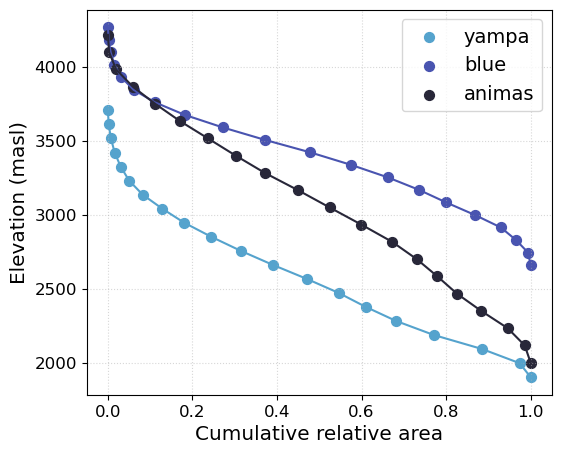

In [21]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Plot hypsometry and snotel points on the same plot
if savefig:
    fig, ax = plt.subplots(1, figsize=(9, 5))
else:
    fig, ax = plt.subplots(1, figsize=(6, 5))
for jdx, (df, basin) in enumerate(zip(df_list, basin_names)):
    # Plot hypsometry area vs elevation for each basin
    ax.scatter(df['cumulative_rel_area'], df['mean_elevation_m'], label=basin, s=50)
    ax.plot(df['cumulative_rel_area'], df['mean_elevation_m'])
    
    # Pull snotel elevations for the basin
    elev_df = pd.Series(basin_elevs[basin])
    
    # Extract SNOTEL stats
    # Plot as shaded areas or dotted horizontal lines at the elevation levels
    _, _, _, snotelmin, low_quart, med, high_quart, snotelmax = elev_df.describe()
    p = 25
    plow = np.nanpercentile(elev_df, p)
    phigh = np.nanpercentile(elev_df, 100-p)

    ax.set_xlabel('Cumulative relative area', fontsize='large')
    ax.set_ylabel('Elevation (masl)', fontsize='large')

plt.legend(bbox_to_anchor=(1,1))
ax.grid(True, linestyle=':', alpha=0.5)
if savefig:
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.tight_layout()
    plt.savefig('hypsometry.png', dpi=300)

## poke at this more

In [16]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

### Env setup

In [17]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [18]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/NWM_datasets_proj4.txt"

In [19]:
# Basin-specific variables
basin = 'blue'
# basin = 'animas'
# basin = 'yampa'


run_aso = True
if basin == 'yampa':
    run_aso = False

# Select just for all variable output of time decay
basindirs = h.fn_list(workdir, f'*{basin}*/wy*/{basin}*/')
_ = [print(b) for b in basindirs]
# Get the WY from the directory name - assumes there is only one WY per basin right now
WYs = [int(basindir.split('wy')[1][:4]) for basindir in basindirs]
WYs = np.unique(WYs)

if len(WYs) > 1:
    print(f'Multiple water years in {basin} basin: {WYs}')
elif len(WYs) == 0:
    print(f'No water years detected in {basin} basin')

WY = WYs[0]
print(WY)

# Adjust basin dirs based on WY
basindirs = h.fn_list(workdir, f'{basin}*/wy{WY}/{basin}*/')

# Figure out filenames
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
print(poly_fn)

/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m/
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo/
2019
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


In [30]:
dt='2019-04-19'
# find isnobal output and compare directly
isnobal_rundirs = [h.fn_list(basindir, f"run{''.join(str(dt).split('-'))}")[0] for basindir in basindirs]
print(isnobal_rundirs)

# Read in snow depths and plot
depth_fns = [proc.fn_list(sdir, "snow.nc")[0] for sdir in isnobal_rundirs]
print(depth_fns)

# Open snow depth files
depths = [np.squeeze(xr.open_mfdataset(depth_fn, decode_coords="all")['thickness']) for depth_fn in depth_fns]

# Set CRS for iSnobal output
depths = [depth.rio.write_crs('epsg:32613', inplace=True) for depth in depths]
depth = depths[0]

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m//run20190419', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo//run20190419']
['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m//run20190419/snow.nc', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m_solar_albedo//run20190419/snow.nc']


In [31]:
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
terrain_fns = h.fn_list(script_dir, f'{basin}*_setup/data/*100m*.tif')
terrain_fns

['/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_aspect.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_hs.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_32613_100m_slope.tif']

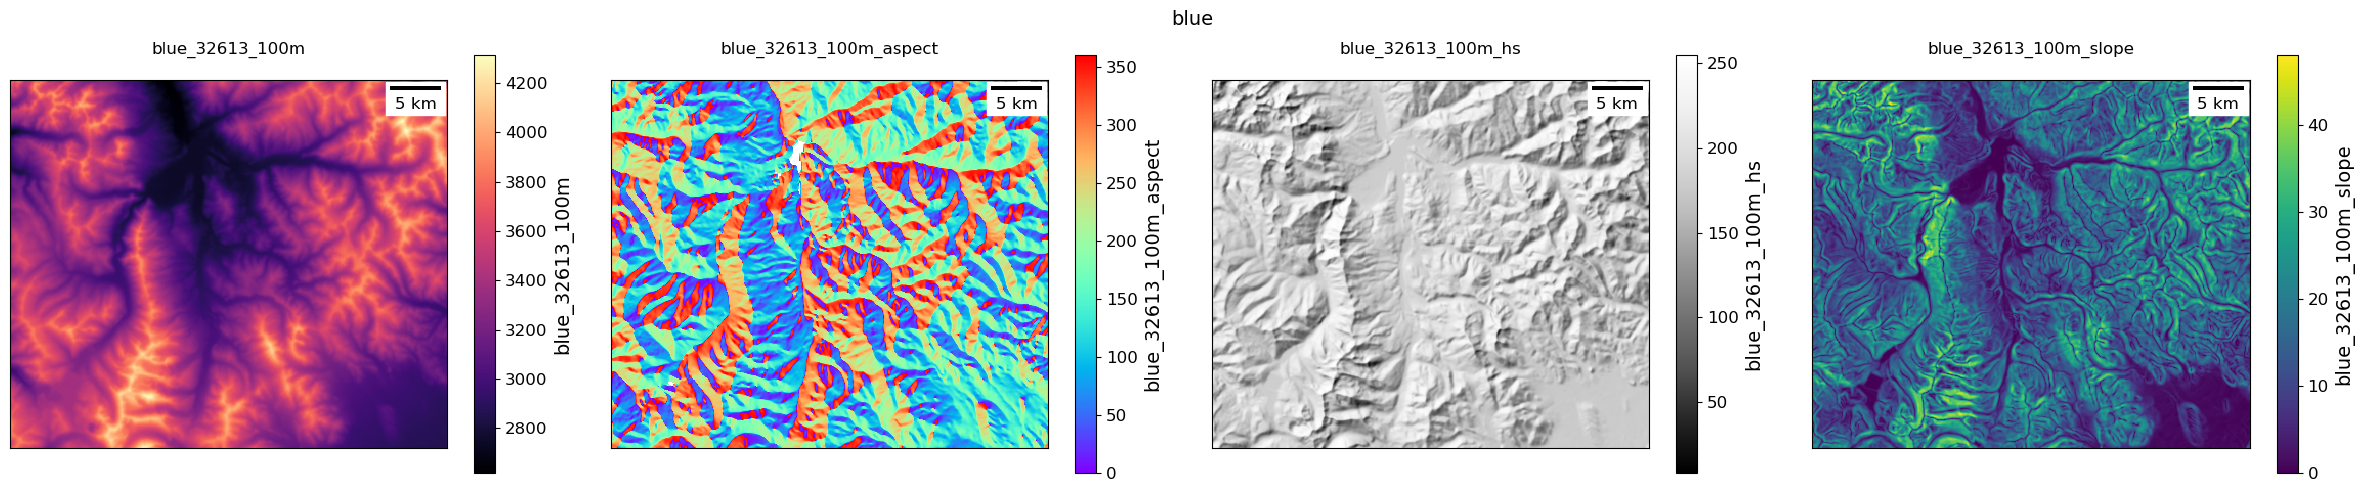

In [32]:
# Load files
terrain_list = [h.load(f) for f in terrain_fns]

# Crop to the same extent as the depth data
cropped_list = [ds.rio.reproject_match(depth) for ds in terrain_list]

# Assign individual varnames for ease of use below
dem, aspect, hs, slope = cropped_list

# Plot them up for a quick view
cmaps = ['magma', 'rainbow', 'Greys_r', 'viridis']
terraintitles = [PurePath(f).stem for f in terrain_fns]

fig, axa = plt.subplots(1, len(cropped_list), figsize=(24, 5))
for jdx, ax in enumerate(axa.flatten()):
    h.plot_one(cropped_list[jdx], cmap=cmaps[jdx], specify_ax=(fig, ax), title=terraintitles[jdx], 
               turnoffaxes=True, turnofflabels=True)
plt.suptitle(f'{basin}')
plt.tight_layout();

Basin area by elevation


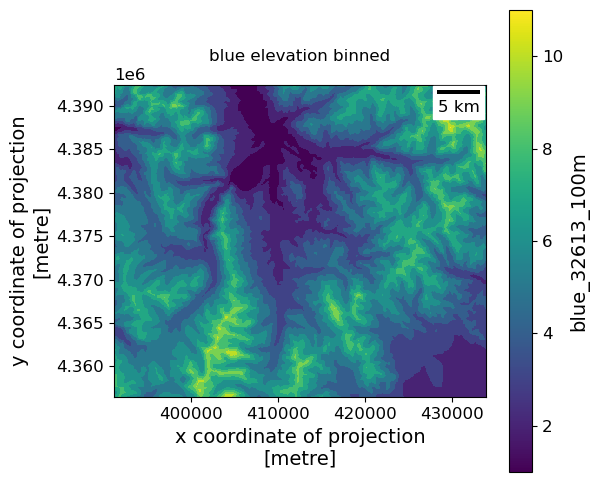

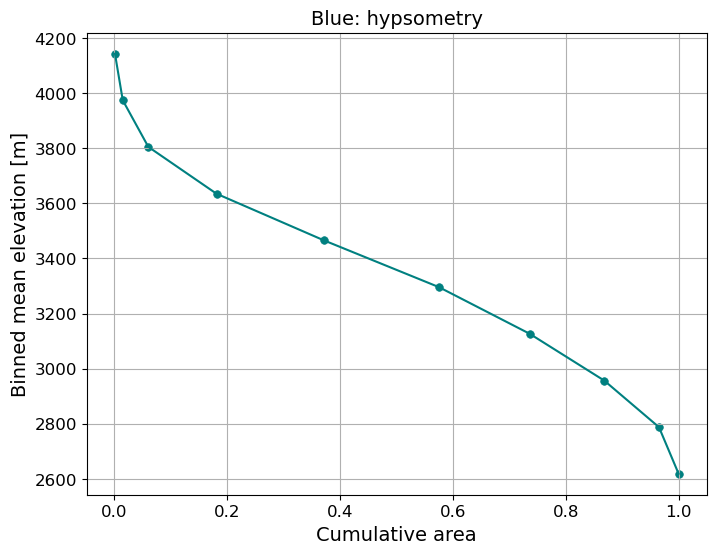

In [138]:
n_bins = 10
dem_bin, dem_elev_ranges = proc.bin_elev(dem, basinname=basin, figsize=(6,6), p=n_bins)
# bin by elevation range
# store the binned and mean values of snow depth difference for that bin in a dict
pixel_res = 100

# Also plot this up
fig, ax = plt.subplots(1, figsize=(8, 6))

print('Basin area by elevation')
mean_elevs = []
low_elevs = []
total_areas = [1] # start off with 1, as the first bin is the lowest elevation and all of the basin is higher than this
area_slices = []
basin_total = dem.size * pixel_res ** 2
for kdx, elev_range in enumerate(dem_elev_ranges):
    # Extract min and max elevations in that bin
    low, high = dem_elev_ranges[elev_range]        
    band_slice = dem.data[(dem.data>=low) & (dem.data<high)] # all pixels within this elevation band
    band_area = band_slice.size * pixel_res ** 2 # calculate area of pixels within this elevation band
    if kdx == 0:
        # cumulative sum of area, initiate as elevation band area
        running_total = band_area
    else:
        # add to running total
        running_total = running_total + band_area
    
    # calculate mean elevation of this bin for plotting
    mean_elev = (low + high) / 2
    low_elevs.append(low)
    mean_elevs.append(mean_elev)

    # total_areas.append(running_total)
    # append the area of this elevation band to the list
    area_slices.append(band_area)
    # band_area / running_total
    # total_areas.append(band_area / running_total)
    # append the proportion of the basin that is higher than this elevation.
    if kdx == len(dem_elev_ranges)-1:
        pass #low_elevs.append(high)
    else:
        total_areas.append(1 - running_total / basin_total)
    

area_slices = np.array(area_slices)
ax.scatter(total_areas, low_elevs, s=30, c='teal', linewidths=0.5)
ax.plot(total_areas, low_elevs, c='teal')

# ax.legend(bbox_to_anchor=(1,1));
ax.set_xlabel('Cumulative area')
# ax.set_xlabel('Relative area')
ax.set_ylabel('Binned mean elevation [m]');
ax.set_title(f'{basin.capitalize()}: hypsometry');
ax.grid(True)

In [139]:
df = pd.DataFrame({'low_elevation_m': low_elevs, 
                   'cumulative_rel_area': total_areas,
                #    'mean_elevation_m': mean_elevs, 
                #    'total_area_m2': area_slices, 
                #    'elev_range_m': list(dem_elev_ranges.values())
                   }) 
df

,low_elevation_m,cumulative_rel_area
0,2619,1.000000
1,2788,0.965232
2,2957,0.868322
3,3127,0.736137
4,3296,0.575675
5,3466,0.371632
6,3635,0.181678
7,3805,0.060955
8,3974,0.015693
9,4143,0.001850


In [141]:
flatten_dem = dem.data.flatten()
flatten_dem = flatten_dem[~np.isnan(flatten_dem)]
dem.size, flatten_dem.size


(154080, 154080)

In [143]:
for low_thresh in [f[0] for f in dem_elev_ranges.values()]:
# for low_thresh in df['mean_elevation_m']:
    # print(low_thresh)
    pixels_higher_than_thresh = flatten_dem[flatten_dem>low_thresh].size
    print(f'{low_thresh}: {pixels_higher_than_thresh / flatten_dem.size * 100:.1f}%')

2619: 100.0%
2788: 96.5%
2957: 86.8%
3127: 73.6%
3296: 57.6%
3466: 37.2%
3635: 18.2%
3805: 6.1%
3974: 1.6%
4143: 0.2%
